# IBM Quantum Awards: Open Science Prize 2021 Submission
## Simulating Heisenberg XXX Model using Qiskit Pulse.
#### Solution is in the Qiskit Pulse category

### Authors: 

#### Yufeng Bright Ye[1], Lingbang Zhu[2]

[1] Department of Electrical Engineering and Computer Science, MIT, Cambridge, MA, 02139

[2] Department of Chemistry and Chemical Biology, Harvard, Cambridge, MA, 02138


#### In this notebook, we will optimize fidelity with 3 strategies: 
## I. Trotterization optimization,
## II. Pulse optimization,
## III. Error Mitigation.
#### For detailed documentation and discussion, see supplemental PDF

Please run cells in order.

Import:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts

# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z, H

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Install plotting package
!pip install pylatexenc

In [3]:
# Importing standard Qiskit modules
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile, schedule
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter

# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# load IBMQ Account data

IBMQ.save_account('2b8218f150600ba6d35be3868c1b178cce4f5139ac2d56ea06d87616b9b84fca017047b84fe28a3ceb7629ec56f36490a4e56375c081b4de68adeab5fb146c25')  # replace TOKEN with your API token string (https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq)
provider = IBMQ.load_account()

configrc.store_credentials:WARNING:2022-04-16 20:10:37,523: Credentials already present. Set overwrite=True to overwrite.


## Section I. Trotterization Optimization 

## Compares 3 Trotterization strategies on noiseless simulator 

### i. Default given by IBM
### ii. Reordered terms 
### iii. Reordered terms + symmetry protection (Tran et al. 2021)

In [5]:
# Noiseless simulated backend
sim = QasmSimulator()

N_array = np.arange(4,25,3) ## the Trotter steps to simulate for

In [6]:
# Compute the state tomography based on the st_qcs quantum circuits and the results from those ciricuits
def state_tomo(result, st_qcs):
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    # Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

### I. i. Default Trotterization given

This is the default Trotterization given in A.J.Rasmusson's starting code 

In [7]:
# Parameterize variable t to be evaluated at t=pi later
t = Parameter('t')

In [8]:
# Build a subcircuit for XX(t) two-qubit gate
XX_qr = QuantumRegister(2)
XX_qc = QuantumCircuit(XX_qr, name='XX')

XX_qc.ry(np.pi/2,[0,1])
XX_qc.cnot(0,1)
XX_qc.rz(2 * t, 1)
XX_qc.cnot(0,1)
XX_qc.ry(-np.pi/2,[0,1])

# Convert custom quantum circuit into a gate
XX = XX_qc.to_instruction()

# Build a subcircuit for YY(t) two-qubit gate
YY_qr = QuantumRegister(2)
YY_qc = QuantumCircuit(YY_qr, name='YY')

YY_qc.rx(np.pi/2,[0,1])
YY_qc.cnot(0,1)
YY_qc.rz(2 * t, 1)
YY_qc.cnot(0,1)
YY_qc.rx(-np.pi/2,[0,1])

# Convert custom quantum circuit into a gate
YY = YY_qc.to_instruction()

# Build a subcircuit for ZZ(t) two-qubit gate
ZZ_qr = QuantumRegister(2)
ZZ_qc = QuantumCircuit(ZZ_qr, name='ZZ')

ZZ_qc.cnot(0,1)
ZZ_qc.rz(2 * t, 1)
ZZ_qc.cnot(0,1)

# Convert custom quantum circuit into a gate
ZZ = ZZ_qc.to_instruction()

# Combine subcircuits into a single multiqubit gate representing a single trotter step
num_qubits = 3

Trot_qr = QuantumRegister(num_qubits)
Trot_qc = QuantumCircuit(Trot_qr, name='Trot')

for i in range(0, num_qubits - 1):
    Trot_qc.append(ZZ, [Trot_qr[i], Trot_qr[i+1]])
    Trot_qc.append(YY, [Trot_qr[i], Trot_qr[i+1]])
    Trot_qc.append(XX, [Trot_qr[i], Trot_qr[i+1]])

# Convert custom quantum circuit into a gate
Trot_gate = Trot_qc.to_instruction()

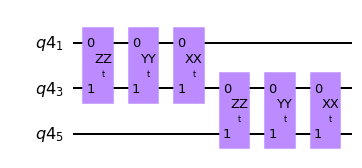

In [9]:
## Plot the circuit for one of them.

# The final time of the state evolution
target_time = np.pi

# Initialize quantum circuit for 3 qubits
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)

# Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)

qc.append(ZZ, [1,3])
qc.append(YY, [1,3])
qc.append(XX, [1,3])

qc.append(ZZ, [3,5])
qc.append(YY, [3,5])
qc.append(XX, [3,5])

## Draw a typical Trotter step
qc.draw(idle_wires=False, output='mpl')

In [10]:
## Get noiseless fidelity vs. Trotter steps (takes ~2 minutes to run)

shots = 8192
reps = 1 # saves time, no difference from 8 since it's simulator
backend = sim

fid_with_N_default = []

for trotter_steps in N_array:
    
    # The final time of the state evolution
    target_time = np.pi

    # Initialize quantum circuit for 3 qubits
    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)

    # Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
    qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

    # Simulate time evolution under H_heis3 Hamiltonian
    for _ in range(trotter_steps):
        qc.append(Trot_gate, [qr[1], qr[3], qr[5]])

    # Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
    qc = qc.bind_parameters({t: target_time/trotter_steps})

    # Generate state tomography circuits to evaluate fidelity of simulation
    st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])

    
    jobs = []
    for _ in range(reps):
        # execute
        job = execute(st_qcs, backend, shots=shots)
        print('Job ID', job.job_id())
        jobs.append(job)

    for job in jobs:
        job_monitor(job)
        try:
            if job.error_message() is not None:
                print(job.error_message())
        except:
            pass



    # Compute tomography fidelities for each repetition
    fids = []
    for job in jobs:
        fid = state_tomo(job.result(), st_qcs)
        fids.append(fid)

    fid_with_N_default.append(np.mean(fids))
    

Job ID ab38d9ca-bd1b-49f8-b9c2-6752d03324d3
Job Status: job has successfully run
Job ID 1e772d9c-052e-40ec-9def-271c1e56acca
Job Status: job has successfully run
Job ID 64ee17bd-bf7e-4f14-b634-2f2d1e04f158
Job Status: job has successfully run
Job ID 7db4856f-8e73-4654-b2de-9bc304a20caf
Job Status: job has successfully run
Job ID afc13733-ae51-4aa5-8b95-8992c5876035
Job Status: job has successfully run
Job ID 0f9a7178-b41a-4664-ad35-794b02303d13
Job Status: job has successfully run
Job ID 333385b6-b988-4fb5-b017-c85affd5d5c1
Job Status: job has successfully run


### I. ii. Reordered terms

This is a different Trotterization with reordered terms, we use it because Tran et al. 2021 uses it as default (https://arxiv.org/pdf/2006.16248.pdf, Eqn 34-35)

In [11]:
# Combine subcircuits into a single multiqubit gate representing a single trotter step
num_qubits = 3

Trot_qr = QuantumRegister(num_qubits)
Trot_qc = QuantumCircuit(Trot_qr, name='Trot')

## All X All Y All Z
Trot_qc.append(XX, [Trot_qr[0], Trot_qr[1]])
Trot_qc.append(XX, [Trot_qr[1], Trot_qr[2]])
Trot_qc.append(YY, [Trot_qr[0], Trot_qr[1]])
Trot_qc.append(YY, [Trot_qr[1], Trot_qr[2]])
Trot_qc.append(ZZ, [Trot_qr[0], Trot_qr[1]])
Trot_qc.append(ZZ, [Trot_qr[1], Trot_qr[2]])

# Convert custom quantum circuit into a gate
Trot_gate_reordered = Trot_qc.to_instruction()

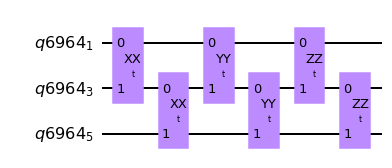

In [12]:
## Draw 1 Trotter step 

# Combine subcircuits into a single multiqubit gate representing a single trotter step

Trot_qr = QuantumRegister(7)
Trot_qc = QuantumCircuit(Trot_qr, name='Trot')

## All X All Y All Z
Trot_qc.append(XX, [Trot_qr[1], Trot_qr[3]])
Trot_qc.append(XX, [Trot_qr[3], Trot_qr[5]])
Trot_qc.append(YY, [Trot_qr[1], Trot_qr[3]])
Trot_qc.append(YY, [Trot_qr[3], Trot_qr[5]])
Trot_qc.append(ZZ, [Trot_qr[1], Trot_qr[3]])
Trot_qc.append(ZZ, [Trot_qr[3], Trot_qr[5]])

## Draw a typical Trotter step
Trot_qc.draw(idle_wires=False, output='mpl')

In [13]:
## Get noiseless fidelity vs. Trotter steps (takes ~2 minutes to run)

shots = 8192
reps = 1 # saves time, no difference from 8 since it's simulator
backend = sim

### accumulate fidelity vs N
fid_with_N_reordered = []

for trotter_steps in N_array:
    
    # The final time of the state evolution
    target_time = np.pi

    # Initialize quantum circuit for 3 qubits
    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)

    # Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
    qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

    # Simulate time evolution under H_heis3 Hamiltonian
    for _ in range(trotter_steps):
        qc.append(Trot_gate_reordered, [qr[1], qr[3], qr[5]])

    # Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
    qc = qc.bind_parameters({t: target_time/trotter_steps})

    # Generate state tomography circuits to evaluate fidelity of simulation
    st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])

    
    jobs = []
    for _ in range(reps):
        # execute
        job = execute(st_qcs, backend, shots=shots)
        print('Job ID', job.job_id())
        jobs.append(job)

    for job in jobs:
        job_monitor(job)
        try:
            if job.error_message() is not None:
                print(job.error_message())
        except:
            pass



    # Compute tomography fidelities for each repetition
    fids = []
    for job in jobs:
        fid = state_tomo(job.result(), st_qcs)
        fids.append(fid)

    fid_with_N_reordered.append(np.mean(fids))
    

Job ID 337e54c5-20f2-4cf1-9b62-5468b78dc1fe
Job Status: job has successfully run
Job ID cb937bf3-b1e3-4509-af9d-df047e759b20
Job Status: job has successfully run
Job ID d2181c48-d5b2-4759-92ba-6bc2eec0c1e9
Job Status: job has successfully run
Job ID aa61c8fe-5a94-48a6-9bca-f68fe2dd3899
Job Status: job has successfully run
Job ID a628a140-0a9a-4000-80da-f577133b1082
Job Status: job has successfully run
Job ID b2520dec-a107-4ee9-811b-ae5186a03dd3
Job Status: job has successfully run
Job ID c9eb903e-f8e6-4683-bde0-842779356f12
Job Status: job has successfully run


### I. iii. Reordered terms + symmetry protection (Tran et al. 2021)

Following https://arxiv.org/pdf/2006.16248.pdf Eqn. 36, 39, by adding Hadamard gates can reduce Trotterization error by symmetry protection.  

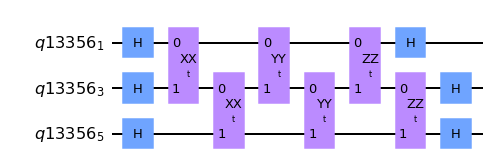

In [14]:
# Combine subcircuits into a single multiqubit gate representing a single trotter step. 
# The example here shows the odd Trotter steps.
# The even Trotter steps don't have the Hadamard gates.

Trot_qr = QuantumRegister(7)
Trot_qc = QuantumCircuit(Trot_qr, name='Trot')

Trot_qc.h([1,3,5]) # adding Hadamards for symmetry protection

## All X All Y All Z
Trot_qc.append(XX, [Trot_qr[1], Trot_qr[3]])
Trot_qc.append(XX, [Trot_qr[3], Trot_qr[5]])
Trot_qc.append(YY, [Trot_qr[1], Trot_qr[3]])
Trot_qc.append(YY, [Trot_qr[3], Trot_qr[5]])
Trot_qc.append(ZZ, [Trot_qr[1], Trot_qr[3]])
Trot_qc.append(ZZ, [Trot_qr[3], Trot_qr[5]])

Trot_qc.h([1,3,5]) # adding Hadamards for symmetry protection 

## Draw a typical Trotter step
Trot_qc.draw(idle_wires=False, output='mpl')


In [15]:
## Get noiseless fidelity vs. Trotter steps (takes ~2 minutes to run)

shots = 8192
reps = 1 # saves time, no difference from 8 since it's simulator
backend = sim

### accumulate fidelity vs N
fid_with_N_symmetry = []

for trotter_steps in N_array:
    
    # The final time of the state evolution
    target_time = np.pi

    # Initialize quantum circuit for 7 qubits
    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)

    # Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
    qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

    # index from 1 to be explicitly consistent with Tran et al.
    for k in range(1,trotter_steps+1):
        
        if k%2 == 1:
            qc.h([1,3,5]) # Hadamards for symmetry
            qc.append(Trot_gate_reordered, [qr[1], qr[3], qr[5]])
            qc.h([1,3,5]) # Hadamards for symmetry
        else:
            qc.append(Trot_gate_reordered, [qr[1], qr[3], qr[5]])
            
    # Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
    qc = qc.bind_parameters({t: target_time/trotter_steps})

    # Generate state tomography circuits to evaluate fidelity of simulation
    st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])

    
    jobs = []
    for _ in range(reps):
        # execute
        job = execute(st_qcs, backend, shots=shots)
        print('Job ID', job.job_id())
        jobs.append(job)

    for job in jobs:
        job_monitor(job)
        try:
            if job.error_message() is not None:
                print(job.error_message())
        except:
            pass



    # Compute tomography fidelities for each repetition
    fids = []
    for job in jobs:
        fid = state_tomo(job.result(), st_qcs)
        fids.append(fid)

    fid_with_N_symmetry.append(np.mean(fids))
    

Job ID bc3adb64-2f5e-4c0e-b642-90f881984a1d
Job Status: job has successfully run
Job ID 02fd2952-5880-4f55-85c1-c892b663ee5f
Job Status: job has successfully run
Job ID bfa4b347-0015-4df5-b067-bfe9c4ed6c08
Job Status: job has successfully run
Job ID 7f1df097-e76e-4762-bd5e-2794d70041c3
Job Status: job has successfully run
Job ID 09412fdf-e6c8-4931-830f-7279b1507d65
Job Status: job has successfully run
Job ID dbc38ddf-d54d-42e9-b3b2-06b0be68c895
Job Status: job has successfully run
Job ID 3a4de2bb-f268-4826-b769-dda8fec66dc9
Job Status: job has successfully run


#### Compare theoretical performance of different Trotterization:
Reordered + symmetry achieves almost perfect theoretical fidelity at Trotter step = 4 and improves over Reordered at large Trotter steps. 

Though Reordered + symmetry seems slightly worse than Given default, this comparison is meaningless. The proper comparison should be between Given default and Given default + symmetry to see the effect of symmetry protection, however Tran et al. 2021 hasn't calculated what the right symmetry protection unitaries are for the Given default, so we are going with Reordered to be consistent with their results.

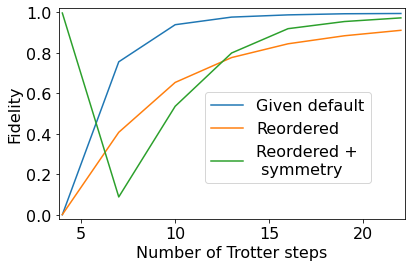

In [16]:
fig, ax = plt.subplots(tight_layout=True)

ax.plot(N_array, fid_with_N_default, label='Given default')
ax.plot(N_array, fid_with_N_reordered, label='Reordered')
ax.plot(N_array, fid_with_N_symmetry, label='Reordered + \n symmetry')

ax.set_xlim([min(N_array)-.2,max(N_array)+.2])
ax.set_ylim([-0.02,1.02])

ax.set_xlabel('Number of Trotter steps')
ax.set_ylabel('Fidelity')

ax.legend(bbox_to_anchor=(0.4, 0.64))

#plt.savefig('Fid_vs_Trotter.pdf')

(To save time for the judge, we only simulated every 3 Trotter steps in this notebook, the result with every single Trotter steps is shown in the supplementary PDF and can be obtained by changing N_array step size above and rerunning.)

Hereafter we will only use 4 Trotter steps of Reordered + symmetry since it achieves such high theoretical fidelity with the minimal number of Trotter steps. Using the minimal 4 Trotter steps minimizes circuit depth and should translate to high fidelity on experimental device)

## Section II. Pulse Optimization 

## Compares experimental results with 4 Trotter steps of Reordered + symmetry for:

### i. Default native CX
### ii. CX using pulse efficient RZX 

In [17]:
# Get backend for experiment

provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
backend = provider.get_backend('ibmq_jakarta') # using actual Jakarta for experiments

from qiskit.transpiler import PassManager

# This function will pull pulse-level calibration values to build RZX gates and tell the PassManager to leave RZX gates alone
from qiskit.transpiler.passes import RZXCalibrationBuilderNoEcho


### II. i. Default native CX 

implementation of 4 Trotter steps of Reordered + symmetry protection

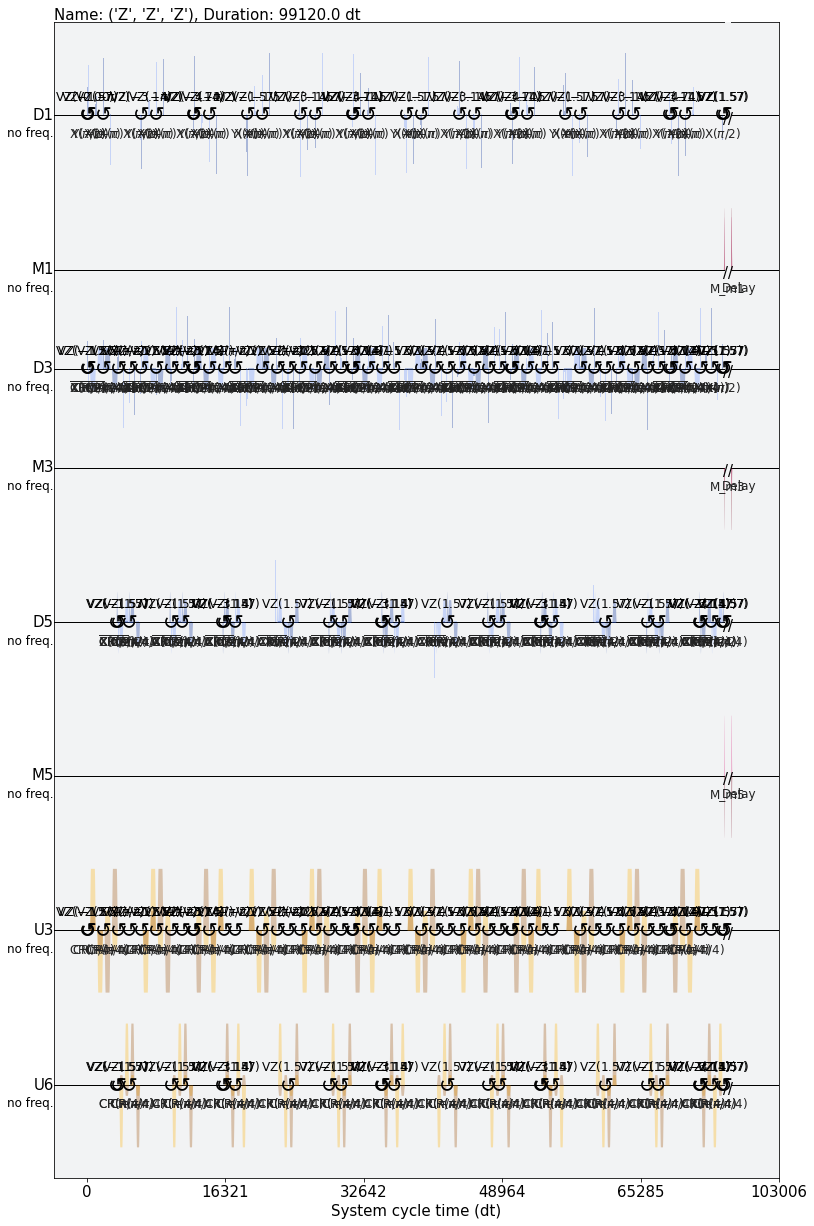

In [18]:
# The final time of the state evolution
target_time = np.pi

# Number of trotter steps
trotter_steps = 4  ### CAN BE >= 4

# Initialize quantum circuit for 3 qubits
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)

# Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

# Simulate time evolution under H_heis3 Hamiltonian    
for k in range(1, trotter_steps+1):
        
        if k%2 != 1:
            qc.h([1,3,5])
            qc.append(Trot_gate_reordered, [qr[1], qr[3], qr[5]])
            qc.h([1,3,5])            
        else:
            qc.append(Trot_gate_reordered, [qr[1], qr[3], qr[5]])
        
# Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
qc = qc.bind_parameters({t: target_time/(trotter_steps)})

# Generate state tomography circuits to evaluate fidelity of simulation
st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])

# Display circuit for confirmation
# st_qcs[-1].decompose().draw()  # view decomposition of trotter gates
st_qcs[-1].draw()  # only view trotter gates
qc_native_pulse = transpile(st_qcs, backend)
schedule(qc_native_pulse[-1], backend).draw() 

The full pulse schedule is hard to see, in the supplemental PDF, we also show the pulse schedule with just 1 Trotter step for clarity.

In [19]:
## Experimental run (intermediary result so only used 1 rep)

# shots = 8192
# backend = backend # jakarta experimental
# job_native_gate = execute(st_qcs, backend, shots=shots)
# print('Job ID', job_native_gate.job_id())
## uncomment this ^ and comment below if you want to run your own job (takes a while)

## showing results from an experimental job we ran: 
job_native_gate = backend.retrieve_job('61e78bfb4ddc9ffdfd80c32c') # comment out if running your own

fid = state_tomo(job_native_gate.result(), qc_native_pulse)
    
print('state tomography fidelity = {:.4f}'.format(fid))

state tomography fidelity = 0.4657


### II. ii. CX using pulse efficient RZX

implementation of 4 Trotter steps of Reordered + symmetry protection using pulse efficient RZX (see PDF for more details)

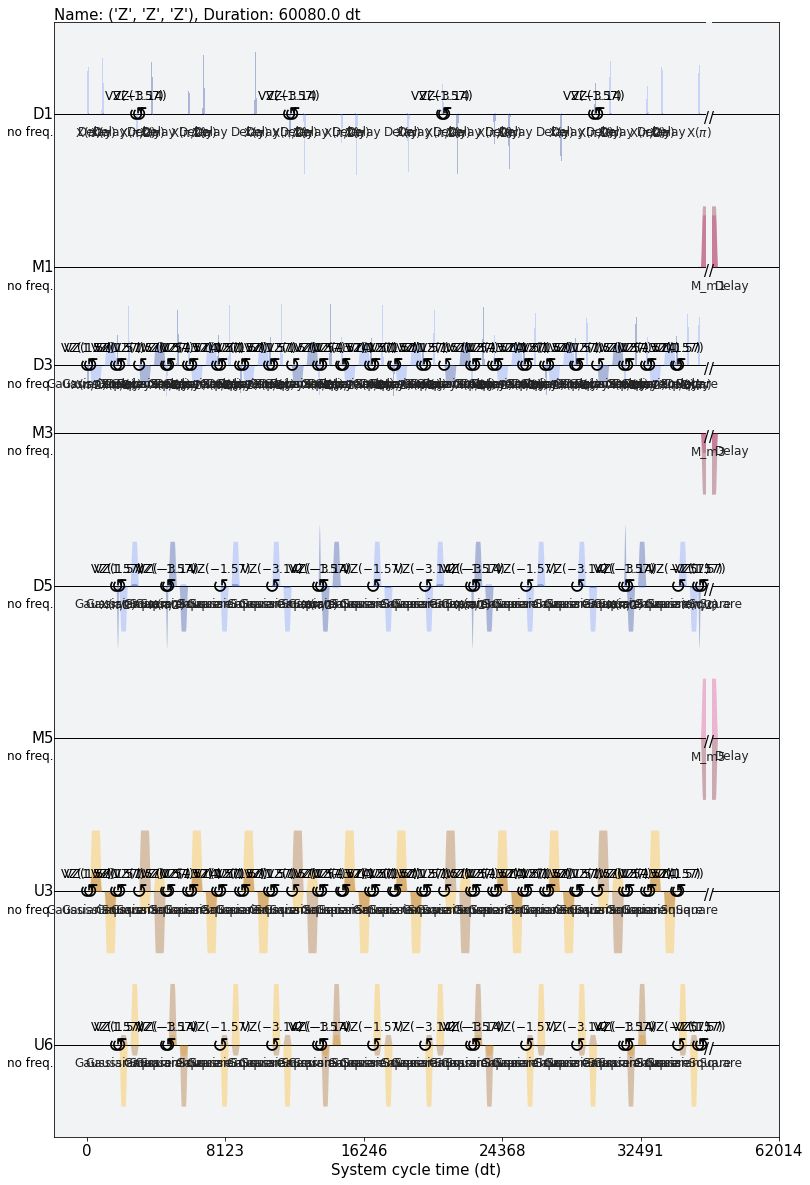

In [20]:
# The final time of the state evolution
target_time = np.pi

# Number of trotter steps
trotter_steps = 4  ### CAN BE >= 4
t = target_time/(trotter_steps)
# Initialize quantum circuit for 3 qubits
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)

# Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

for i in range(1,trotter_steps+1):    
        
    if i%2 == 1:
        # Symmetrization
        qc.h([1,3,5])
        
    # XX of 1,3
    qc.ry(np.pi/2,[1,3])
    qc.h(3)
    qc.rzx(t, 1, 3)
    qc.x(1)
    qc.rzx(-t, 1, 3)
    qc.x(1)
    qc.h(3)
    qc.ry(-np.pi/2,[1,3])

    # XX of 3,5
    qc.ry(np.pi/2,[3,5])
    qc.h(5)
    qc.rzx(t, 3, 5)
    qc.x(3)
    qc.rzx(-t, 3, 5)
    qc.x(3)
    qc.h(5)
    qc.ry(-np.pi/2,[3,5])
    
    # YY of 1,3
    qc.rx(np.pi/2,[1,3])
    qc.h(3)
    qc.rzx(t, 1, 3)
    qc.x(1)
    qc.rzx(-t, 1, 3)
    qc.x(1)
    qc.h(3)
    qc.rx(-np.pi/2,[1,3])

    # YY of 3,5
    qc.rx(np.pi/2,[3,5])
    qc.h(5)
    qc.rzx(t, 3, 5)
    qc.x(3)
    qc.rzx(-t, 3, 5)
    qc.x(3)
    qc.h(5)
    qc.rx(-np.pi/2,[3,5])
    
    # ZZ of 1,3
    qc.h(3)
    qc.rzx(t, 1, 3)
    qc.x(1)
    qc.rzx(-t, 1, 3)
    qc.x(1)
    qc.h(3)

    # ZZ of 3,5
    qc.h(5)
    qc.rzx(t, 3, 5)
    qc.x(3)
    qc.rzx(-t, 3, 5)
    qc.x(3)
    qc.h(5)
    
    # Hadamard for Symmetrization
    if i%2 == 1:
        qc.h([1,3,5])

st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])

pm = PassManager([RZXCalibrationBuilderNoEcho(backend)]) ## calibrate pulse efficient RZX
qc_pulse_efficient = pm.run(st_qcs)
qc_pulse_efficient = transpile(qc_pulse_efficient, backend)
schedule(qc_pulse_efficient[-1], backend).draw() 

The full pulse schedule is hard to see, in the supplemental PDF, we also show the pulse schedule with just 1 Trotter step for clarity.

Notice that the pulse efficient RZX implementation is much shorter (~60k vs. ~100k cycles) than the default with native CX. This leads to higher fidelity from shorter overall time and so less qubit decoherence.

In [21]:
## Experimental run (key result with 8 reps)

# shots = 8192
# backend = backend # jakarta experimental
# reps = 8
# jobs_efficient_pulse = []
# for _ in range(reps):
#     # execute
#     job = execute(st_qcs, backend, shots=shots)
#     print('Job ID', job.job_id())
#     jobs_efficient_pulse.append(job)
## uncomment this ^ and comment below if you want to run your own jobs (takes a while)

## showing results from an 8 rep experimental job we ran: 
job1 = backend.retrieve_job('61f1f35c6fb7974b7a444c8a')
job2 = backend.retrieve_job('61f1f35eded89e3571aa0ecf')
job3 = backend.retrieve_job('61f1f3601faa062ab2348503')
job4 = backend.retrieve_job('61f1f362dfe4a9d6ab2303e0')
job5 = backend.retrieve_job('61f1f3647f4bf83899bd7679')
job6 = backend.retrieve_job('61f1f366dfe4a90cf72303e1')
job7 = backend.retrieve_job('61f1f3684eebda8a407ab26a')
job8 = backend.retrieve_job('61f1f3694ddc9ff46980fe47')
jobs_efficient_pulse = [job1, job2, job3, job4, job5, job6, job7, job8] # comment out if running your own

# Compute tomography fidelities for each repetition
fids = []
for job in jobs_efficient_pulse:
    fid = state_tomo(job.result(), qc_pulse_efficient)
    fids.append(fid)
    
print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity = 0.7032 ± 0.0036


As expected, results with efficient pulse is significantly higher fidelity (70.3% vs 46.6%) than results with native gates. From here on we will only use efficient pulse and focus on applying error mitigation to further improve fidelity.

## Section III. Error Mitigation

## Improve experimental results with 4 Trotter steps of Reordered + symmetry and pulse efficient RZX using: 

### i. Measurement error mitigation
### ii. Zero-noise (Richardson) extrapolation 

In [22]:
# Import measurement calibration functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

### III. i. Measurement error mitigation

We continue from section II. ii. and apply measurement error mitigation with the calibration job we ran right before those jobs (or run your own calibration here if you ran your own jobs above).  

In [23]:
# Generate the calibration circuits
qr = QuantumRegister(7)
qubit_list = [1,3,5]
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')

In [24]:
## Experimental calibration of measurement error

# # Generate the calibration circuits
# meas_error_mit_job = execute(meas_calibs, backend=backend, shots=8192)
# print('Job ID', meas_error_mit_job.job_id())
# # uncomment this ^ and comment below if you want to run your own jobs (takes a while)

meas_error_mit_job = backend.retrieve_job('61ef6b7a4ddc9f071280efaf') # comment out if running your own

cal_results = meas_error_mit_job.result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
#print(meas_fitter.cal_matrix)

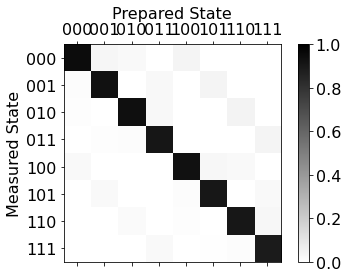

In [25]:
# plot measurement error mitigation calibration
meas_fitter.plot_calibration()
meas_filter = meas_fitter.filter

In [26]:
# Compute the state tomography based on the st_qcs quantum circuits and the results from those ciricuits
def state_tomo(result, qc_pulse_efficient):
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    
    # Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, qc_pulse_efficient)
    rho_fit = tomo_fitter.fit(method='lstsq')
    
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

# Compute the state tomography + measurement error mitigation
def state_tomo_meas_mit(result, qc_pulse_efficient):
    '''
    Like state_tomo except applies measurement error mitigation
    '''
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()  # (|q_5,q_3,q_1> = |011>)
    
    # Fit state tomography results after measurement error mitigation
    mitigated_results = meas_filter.apply(result)
    tomo_fitter = StateTomographyFitter(mitigated_results, qc_pulse_efficient)
    
    rho_fit = tomo_fitter.fit(method='lstsq')
    
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

In [27]:
# Compute tomography fidelities for each repetition
fids = []
for job in jobs_efficient_pulse:
    fid = state_tomo_meas_mit(job.result(), qc_pulse_efficient)
    fids.append(fid)
    
print('state tomography fidelity (with measurement error mitigation) = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity (with measurement error mitigation) = 0.7695 ± 0.0041


Measurement error mitigation improves fidelity by about 7% (77.0% vs. 70.3%). We will also apply measurement error mitigation in the zero-noise extrapolation below.

### III. ii. Zero-noise extrapolation (ZNE) or Richardson extrapolation

See supplementary PDF for explanation of how stretched RZX pulses are programmed.

In [28]:
from stretch_pulse import *  # import script for stretching pulses

In [29]:
from scipy.optimize import curve_fit

## use a linear fit function
def linear(x, a, b):
    return a * x + b

In [30]:
def fit_results(scale, results, stretch_extrap=0):
    '''
    Args:
    
        scale: an array-like object storing the various stretch factors (e.g. [0.9,1,2])
        results: an array-like object storing the job.result() corresponding to each stretch factor
        stretch_extrap: float <= min(scale) to extrapolate noise to, usually 0
    
    Returns:
    
        results0: result object extrapolated to given stretch_extrap
        NegativeFlag: flag that = True if fit extrapolates to negative counts
    '''
    
    NegativeFlag = False # initialize a NegativeFlag that = True if fit extrapolates to negative counts
    cts_basis_array = ['000','001','010','011','100','101','110','111']
    results_basis_array = ['0x0','0x1','0x2','0x3','0x4','0x5','0x6','0x7']
    
    popt = [0, 2e3] # guesses to the linear fit.
    
    # get a dictionary for result object (took the 1st arbitrarily), will be modified with fitted result
    result_dict = results[0].to_dict() 

    # create result0 counts object to be returned
    result0_cts = []
    for i in range(27):
        result0_cts.append({})
    
    # Loop to fit all 27 state tomography circuit results:
    for i in range(27):
        basis_sum = 0 # keep track of fitted sum to renormalize
        for (j, basis) in enumerate(cts_basis_array):  
            # set zero count for undefined dictionary keys
            for k in range(len(results)):
                if basis not in results[k].get_counts()[i].keys():
                    results[k].get_counts()[i][basis] = 0
            
            cts_array = [results[k].get_counts()[i][basis] for k in range(len(results))]
            popt, pcov = curve_fit(linear, scale, cts_array, p0=popt) # fit counts to linear model

            fit_result = popt[1] + popt[0]*stretch_extrap # y intercept + slope * x_extrap
            
            # negative counts will trigger error later so we want to catch it here
            if fit_result < 0:
                NegativeFlag = True
                
            result0_cts[i][results_basis_array[j]] = fit_result # add fit result to be returned
            basis_sum += fit_result # keep track of total fitted counts to renormalize

        # renormalize to 8192 shots
        for results_basis in results_basis_array:    
            result0_cts[i][results_basis] = result0_cts[i][results_basis] / basis_sum * 8192

        result_dict["results"][i]['data']['counts'] = result0_cts[i] # update dictionary with fitted counts

    results0 = results[0].from_dict(result_dict) # create new result object from dictionary of fitted counts
    
    return results0, NegativeFlag

#### Load measurement error mitigation for the ZNE experiments

Alternatively, if (immediately prior to this) you ran your own measurement error mitigation from Section III. i. comment out the next 3 cells below and proceed to the creating your own new pulse stretching jobs

In [31]:
#Error mitigation
meas_error_mit_job = backend.retrieve_job('624f9521d720331d4367df0f')
cal_results = meas_error_mit_job.result()

In [32]:
# Generate the calibration circuits
qr = QuantumRegister(7)
qubit_list = [1,3,5]
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')
state_labels
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
#print(meas_fitter.cal_matrix)

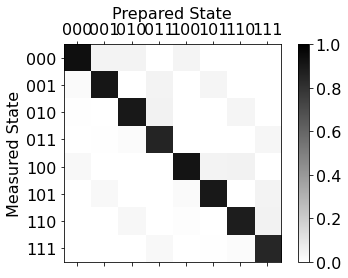

In [33]:
meas_fitter.plot_calibration()
meas_filter = meas_fitter.filter

#### Load / run new stretched pulse results:

In [34]:
## Important: some stretch scale / factor can be too low 
# and cause issues with high pulse amplitude required 
# to keep area constant. stretching >0.82 is recommended.
scale = [0.82, 1.0, 1.5, 2.0, 2.5] # stretch factors used -- keep the number fixed or change code below accordingly

Uncomment this cell if you want to run your own jobs with stretched RZX pulses

In [35]:
# ## Uncomment if judge wants to run your own stretched RZX pulse jobs

# ## Generating the standard qc of 4 Trotter step re-ordered + symmetry:
# # The final time of the state evolution
# target_time = np.pi

# # Number of trotter steps
# trotter_steps = 4  ### CAN BE >= 4
# t = target_time/(trotter_steps)
# # Initialize quantum circuit for 3 qubits
# qr = QuantumRegister(7)
# qc = QuantumCircuit(qr)

# # Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
# qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

# for i in range(1,trotter_steps+1):    
        
#     if i%2 == 1:
#         # Symmetrization
#         qc.h([1,3,5])
        
#     # XX of 1,3
#     qc.ry(np.pi/2,[1,3])
#     qc.h(3)
#     qc.rzx(t, 1, 3)
#     qc.x(1)
#     qc.rzx(-t, 1, 3)
#     qc.x(1)
#     qc.h(3)
#     qc.ry(-np.pi/2,[1,3])

#     # XX of 3,5
#     qc.ry(np.pi/2,[3,5])
#     qc.h(5)
#     qc.rzx(t, 3, 5)
#     qc.x(3)
#     qc.rzx(-t, 3, 5)
#     qc.x(3)
#     qc.h(5)
#     qc.ry(-np.pi/2,[3,5])
    
#     # YY of 1,3
#     qc.rx(np.pi/2,[1,3])
#     qc.h(3)
#     qc.rzx(t, 1, 3)
#     qc.x(1)
#     qc.rzx(-t, 1, 3)
#     qc.x(1)
#     qc.h(3)
#     qc.rx(-np.pi/2,[1,3])

#     # YY of 3,5
#     qc.rx(np.pi/2,[3,5])
#     qc.h(5)
#     qc.rzx(t, 3, 5)
#     qc.x(3)
#     qc.rzx(-t, 3, 5)
#     qc.x(3)
#     qc.h(5)
#     qc.rx(-np.pi/2,[3,5])
    
#     # ZZ of 1,3
#     qc.h(3)
#     qc.rzx(t, 1, 3)
#     qc.x(1)
#     qc.rzx(-t, 1, 3)
#     qc.x(1)
#     qc.h(3)

#     # ZZ of 3,5
#     qc.h(5)
#     qc.rzx(t, 3, 5)
#     qc.x(3)
#     qc.rzx(-t, 3, 5)
#     qc.x(3)
#     qc.h(5)
    
#     # Hadamard for Symmetrization
#     if i%2 == 1:
#         qc.h([1,3,5])
        
# st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])

# ## After generating the standard qc of 4 Trotter step re-ordered + symmetry, apply stretching:
# # didn't write a loop to stay consisten with our job retrival cell below

# ## 0.82
# stretch_scale = scale[0] 
# qc_pulse_efficient = get_stretched_pulses(st_qcs, backend, stretch_scale)
# #schedule(qc_pulse_efficient[-1], backend).draw(time_range=(0, 10000)) # uncomment to see stretched schedule
# print(schedule(qc_pulse_efficient[-1], backend).duration)

# # Run stretched pulse jobs
# shots = 8192
# reps = 8
# jobs_stretch_82 = []
# for _ in range(reps):
#     # execute
#     job = execute(qc_pulse_efficient, backend, shots=shots)
#     print('Job ID', job.job_id())
#     jobs_stretch_82.append(job.job_id())

# ## 1.0
# stretch_scale = scale[1] 
# qc_pulse_efficient = get_stretched_pulses(st_qcs, backend, stretch_scale)
# #schedule(qc_pulse_efficient[-1], backend).draw(time_range=(0, 10000)) # uncomment to see stretched schedule
# print(schedule(qc_pulse_efficient[-1], backend).duration)

# # Run stretched pulse jobs
# shots = 8192
# reps = 8
# jobs_stretch_100 = []
# for _ in range(reps):
#     # execute
#     job = execute(qc_pulse_efficient, backend, shots=shots)
#     print('Job ID', job.job_id())
#     jobs_stretch_100.append(job.job_id())

# ## 1.5
# stretch_scale = scale[2] 
# qc_pulse_efficient = get_stretched_pulses(st_qcs, backend, stretch_scale)
# #schedule(qc_pulse_efficient[-1], backend).draw(time_range=(0, 10000)) # uncomment to see stretched schedule
# print(schedule(qc_pulse_efficient[-1], backend).duration)

# # Run stretched pulse jobs
# shots = 8192
# reps = 8
# jobs_stretch_150 = []
# for _ in range(reps):
#     # execute
#     job = execute(qc_pulse_efficient, backend, shots=shots)
#     print('Job ID', job.job_id())
#     jobs_stretch_150.append(job.job_id())

# ## 2.0
# stretch_scale = scale[3] 
# qc_pulse_efficient = get_stretched_pulses(st_qcs, backend, stretch_scale)
# #schedule(qc_pulse_efficient[-1], backend).draw(time_range=(0, 10000)) # uncomment to see stretched schedule
# print(schedule(qc_pulse_efficient[-1], backend).duration)

# # Run stretched pulse jobs
# shots = 8192
# reps = 8
# jobs_stretch_200 = []
# for _ in range(reps):
#     # execute
#     job = execute(qc_pulse_efficient, backend, shots=shots)
#     print('Job ID', job.job_id())
#     jobs_stretch_200.append(job.job_id())

# ## 2.5
# stretch_scale = scale[4] 
# qc_pulse_efficient = get_stretched_pulses(st_qcs, backend, stretch_scale)
# #schedule(qc_pulse_efficient[-1], backend).draw(time_range=(0, 10000)) # uncomment to see stretched schedule
# print(schedule(qc_pulse_efficient[-1], backend).duration)

# # Run stretched pulse jobs
# shots = 8192
# reps = 8
# jobs_stretch_250 = []
# for _ in range(reps):
#     # execute
#     job = execute(qc_pulse_efficient, backend, shots=shots)
#     print('Job ID', job.job_id())
#     jobs_stretch_250.append(job.job_id())

Here we just take results from previously run jobs with stretched RZX pulses.

Comment this cell if you uncommented and ran the cell above

In [36]:

## Load our previous jobs with stretched pulses

# Stretched RZX -> 82% RZX 
jobs_stretch_82 = ['624f9536d72033b5fb67df10',
'624f95385ab79b4850f958cc',
'624f953a182d02fb9c4c3104',
'624f953ccaa265baf6f1a0f7',
'624f953ef65d7852153909a6',
'624f954073968c7aa907b9d6',
'624f95434b5152a2a97c721c',
'624f95455ab79b2acaf958cf']

# Stretched RZX -> 100% RZX 
jobs_stretch_100 = ['624f9533aacb9bfa525f5465',
'624f95355ab79bc3b5f958cb',
'624f9537d7203332c867df11',
'624f95395ab79bfa43f958cd',
 '624f953b182d02b1774c3105',
 '624f953dd72033725f67df13',
 '624f953eaacb9b4c3d5f5466',
 '624f95414b515290707c721b']

# Stretched RZX -> 150% RZX 
jobs_stretch_150 = ['624f9535f65d780d933909a4',
'624f9537182d029cc94c3103',
'624f953aa5d4ee43ed77d3f1',
'624f953bd7203319d067df12',
'624f953ecaa265817ef1a0f8',
'624f954073968c20c407b9d5',
'624f9542a5d4ee936177d3f2',
'624f9545aacb9bb4425f5467']

# Stretched RZX -> 200% RZX 
jobs_stretch_200 = ['624f953ecaa2659ad3f1a0f9',
'624f9540caa2653c3bf1a0fa',
'624f9543caa2658fbef1a0fc',
'624f9545cfe45c7a66e5aa11',
'624f9548f65d7825bf3909a7',
'624f954a182d02bfc94c3107',
'624f954cd72033415067df16',
'624f954e182d02d4924c3108']

# Stretched RZX -> 250% RZX 
jobs_stretch_250 = ['624f953bcaa2656708f1a0f6',
'624f953e182d026f484c3106',
'624f9541caa2653d81f1a0fb',
'624f9543a5d4ee503577d3f3',
'624f9546d72033c17667df14',
'624f9548d7203343ba67df15',
'624f954af65d78b64d3909a8',
'624f954caacb9b891d5f5468']


In [37]:
#This step will take a few minutes since it tries to look for the minimum stretch factor it can extrapolate to without errors

## Retrieve job, if we want to retrieve 8 jobs we need to put them into array / lists 
reps = 8
results_00_array = []


# beware that if extrapolation is too small and data isn't clean, can get negatives which crashes calc below
# Setting up a binary search to figure out the minimum stretch factor we can extrapolate to
stretch_extrap_lower_bound = 0 # The lower bound of the binary search
stretch_extrap_upper_bound = 1 # The upper bound of the binary search
stretch_extrap_average = 0.5 # The average value of the lower and upper bound
stretch_extrap_precision = stretch_extrap_upper_bound - stretch_extrap_lower_bound # The precision of the search
stretch_min_extrap = 0.5 # The minimum extrapolation factor that does not yield a negative count
Negative_Flag_For_Stretch = False # Flag for detecting negative counts for all 8 reps given a specific stretch factor

## Loop through 8 reps to avoid getting negative counts 

while stretch_extrap_precision > 0.02:        
    for rep_num in range(reps):
        
        # Load all completed jobs' results in the same order as the scale list.
        job_stretch_82 = backend.retrieve_job(jobs_stretch_82[rep_num])
        results_82 = job_stretch_82.result()

        job_stretch_100 = backend.retrieve_job(jobs_stretch_100[rep_num])
        results_100 = job_stretch_100.result()

        job_stretch_150 = backend.retrieve_job(jobs_stretch_150[rep_num])
        results_150 = job_stretch_150.result()

        job_stretch_200 = backend.retrieve_job(jobs_stretch_200[rep_num])
        results_200 = job_stretch_200.result()

        job_stretch_250 = backend.retrieve_job(jobs_stretch_250[rep_num])
        results_250 = job_stretch_250.result()

        # same ordering as the list: scale = [0.82, 1.0, 1.5, 2.0, 2.5]
        results = [results_82, results_100, results_150, results_200, results_250]

        # Fit results, the Negative Flag here is for a specific rep
        results_00_data, NegativeFlag = fit_results(scale, results, stretch_extrap=stretch_extrap_average)
        
        # Turn on the 8 rep overall negative flag when we detect negative counts from a single fit
        if (NegativeFlag or Negative_Flag_For_Stretch) == True :
            Negative_Flag_For_Stretch = True    
    
    # Binary search, update to the next step    
    if Negative_Flag_For_Stretch:
        stretch_extrap_lower_bound = stretch_extrap_average
        stretch_min_extrap = stretch_extrap_upper_bound

    else:
        stretch_extrap_upper_bound = stretch_extrap_average
        stretch_min_extrap = stretch_extrap_average
    
    # Update the new average value and precision
    stretch_extrap_average = (stretch_extrap_lower_bound + stretch_extrap_upper_bound)/2
    stretch_extrap_precision = stretch_extrap_upper_bound - stretch_extrap_lower_bound
    
    # Print out the progress of the binary search
    print('Current minimum non negative stretch factor is: ', stretch_min_extrap, 'The range of the search is: [',stretch_extrap_lower_bound, stretch_extrap_upper_bound,']')
    
    if stretch_extrap_precision < 0.02:
        print('Stop, we have enough precision')
    else:
        print('Continue to search with higher precision')
        
    #Reset the flag for each new Stretch factor    
    Negative_Flag_For_Stretch = False

Current minimum non negative stretch factor is:  0.5 The range of the search is: [ 0 0.5 ]
Continue to search with higher precision
Current minimum non negative stretch factor is:  0.25 The range of the search is: [ 0 0.25 ]
Continue to search with higher precision
Current minimum non negative stretch factor is:  0.125 The range of the search is: [ 0 0.125 ]
Continue to search with higher precision
Current minimum non negative stretch factor is:  0.0625 The range of the search is: [ 0 0.0625 ]
Continue to search with higher precision
Current minimum non negative stretch factor is:  0.0625 The range of the search is: [ 0.03125 0.0625 ]
Continue to search with higher precision
Current minimum non negative stretch factor is:  0.0625 The range of the search is: [ 0.046875 0.0625 ]
Stop, we have enough precision


In [38]:
## Get best fidelity from ZNE at the minimum stretch extrapolation 
   
for rep_num in range(reps):

    # Load all completed jobs' results in the same order as the scale list.
    job_stretch_82 = backend.retrieve_job(jobs_stretch_82[rep_num])
    results_82 = job_stretch_82.result()

    job_stretch_100 = backend.retrieve_job(jobs_stretch_100[rep_num])
    results_100 = job_stretch_100.result()

    job_stretch_150 = backend.retrieve_job(jobs_stretch_150[rep_num])
    results_150 = job_stretch_150.result()

    job_stretch_200 = backend.retrieve_job(jobs_stretch_200[rep_num])
    results_200 = job_stretch_200.result()

    job_stretch_250 = backend.retrieve_job(jobs_stretch_250[rep_num])
    results_250 = job_stretch_250.result()

    # same ordering as the list: scale = [0.82, 1.0, 1.5, 2.0, 2.5]
    results = [results_82, results_100, results_150, results_200, results_250]

    # Fit results 
    results_00_data, NegativeFlag = fit_results(scale, results, stretch_extrap=stretch_min_extrap)
    results_00_array.append(results_00_data) 


In [39]:
# Compute tomography fidelities

# no measurement error mitigation
fids = []

for rep_num in range(reps):
    fids.append(state_tomo(results_00_array[rep_num], qc_pulse_efficient))

# yes measurement error mitigation
fids_mit = []

for rep_num in range(reps):
    fids_mit.append(state_tomo_meas_mit(results_00_array[rep_num], qc_pulse_efficient))
    
print('stretch scales:', scale, 'extrapolate to:', stretch_min_extrap )
print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))
print('state tomography (meas. mitigation) fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids_mit), np.std(fids_mit)))

stretch scales: [0.82, 1.0, 1.5, 2.0, 2.5] extrapolate to: 0.0625
state tomography fidelity = 0.7733 ± 0.0068
state tomography (meas. mitigation) fidelity = 0.8692 ± 0.0086


#### Plot of fidelity vs extrapolation showing characteristic Richardson extrapolation (better result but higher noise with more extrapolation)

In [40]:
## Loop over stretch_extrap to get a curve with uncertainties (takes ~8 min)

stretch_extrap_array = np.linspace(stretch_min_extrap,2.5,10) # undersampling to save time, can increase # of points
fids_mit_array = []
fids_std = []

for stretch_extrap in stretch_extrap_array:
    reps = 8
    results_00_array = []
    
    ## Loop to do ZNE for each of the 8 reps
    for rep_num in range(reps):
        
        # Load all completed jobs' results in the same order as the scale list.
        job_stretch_82 = backend.retrieve_job(jobs_stretch_82[rep_num])
        results_82 = job_stretch_82.result()

        job_stretch_100 = backend.retrieve_job(jobs_stretch_100[rep_num])
        results_100 = job_stretch_100.result()
    
        job_stretch_150 = backend.retrieve_job(jobs_stretch_150[rep_num])
        results_150 = job_stretch_150.result()
    
        job_stretch_200 = backend.retrieve_job(jobs_stretch_200[rep_num])
        results_200 = job_stretch_200.result()
    
        job_stretch_250 = backend.retrieve_job(jobs_stretch_250[rep_num])
        results_250 = job_stretch_250.result()
        
        # same ordering as the list: scale = [0.82, 1.0, 1.5, 2.0, 2.5]
        results = [results_82, results_100, results_150, results_200, results_250]
    
        # Fit results 
        results_00_array.append(fit_results(scale, results, stretch_extrap=stretch_extrap)[0]) 

    fids_mit = []
    for i in range(reps):
        # replace "state_tomo_meas_mit" with "state_tomo" if not applying measurement error mitigation
        fids_mit.append(state_tomo_meas_mit(results_00_array[i], qc_pulse_efficient))

    fids_mit_array.append(np.mean(fids_mit))
    fids_std.append(np.std(fids_mit))
    
    print('Stretch_exp = ', stretch_extrap)
    print('Fids_mit = ', np.mean(fids_mit))
    print('Fids_std = ', np.std(fids_mit))

# Cast to numpy arrays for easy plotting below
fids_mit_array = np.array(fids_mit_array)
fids_std = np.array(fids_std)        

Stretch_exp =  0.0625
Fids_mit =  0.8691850810789131
Fids_std =  0.008586316144848774
Stretch_exp =  0.3333333333333333
Fids_mit =  0.8339433618663006
Fids_std =  0.006732006540177021
Stretch_exp =  0.6041666666666666
Fids_mit =  0.7975496134835781
Fids_std =  0.0052419337118994516
Stretch_exp =  0.875
Fids_mit =  0.7607968419592357
Fids_std =  0.003958293485625786
Stretch_exp =  1.1458333333333333
Fids_mit =  0.7241885883130542
Fids_std =  0.0031166143903314705
Stretch_exp =  1.4166666666666665
Fids_mit =  0.6876651783757524
Fids_std =  0.0030590517549259504
Stretch_exp =  1.6875
Fids_mit =  0.6511941558258194
Fids_std =  0.0038091668381487233
Stretch_exp =  1.9583333333333333
Fids_mit =  0.6147556233839027
Fids_std =  0.005013433812716449
Stretch_exp =  2.2291666666666665
Fids_mit =  0.5783361651386087
Fids_std =  0.0064202693436262535
Stretch_exp =  2.5
Fids_mit =  0.5419258529445117
Fids_std =  0.007922188233433958


In [41]:
## get the mitigated but no ZNE fidelity for every run:

fids_82 = []
fids_100 = []
fids_150 = []
fids_200 = []
fids_250 = []
    
for rep_num in range(reps):
        
    job_stretch_82 = backend.retrieve_job(jobs_stretch_82[rep_num])
    fids_82.append(state_tomo_meas_mit(job_stretch_82.result(), qc_pulse_efficient))

    job_stretch_100 = backend.retrieve_job(jobs_stretch_100[rep_num])
    fids_100.append(state_tomo_meas_mit(job_stretch_100.result(), qc_pulse_efficient))

    job_stretch_150 = backend.retrieve_job(jobs_stretch_150[rep_num])
    fids_150.append(state_tomo_meas_mit(job_stretch_150.result(), qc_pulse_efficient))

    job_stretch_200 = backend.retrieve_job(jobs_stretch_200[rep_num])
    fids_200.append(state_tomo_meas_mit(job_stretch_200.result(), qc_pulse_efficient))

    job_stretch_250 = backend.retrieve_job(jobs_stretch_250[rep_num])
    fids_250.append(state_tomo_meas_mit(job_stretch_250.result(), qc_pulse_efficient))

exp_fid = [np.mean(fids_82),np.mean(fids_100),np.mean(fids_150),np.mean(fids_200),np.mean(fids_250)]
exp_fid_error = [np.std(fids_82),np.std(fids_100),np.std(fids_150),np.std(fids_200),np.std(fids_250)]

(0.0, 2.6)

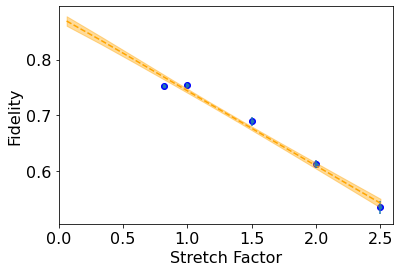

In [42]:
## Data from experiments

# for our runs, check that you get:
#exp_fid = [0.7522,0.7538,0.6887,0.6122,0.5343] 
#exp_fid_error =[0.004, 0.0049, 0.0073, 0.0071, 0.0116]

fig, ax = plt.subplots()

ax.scatter(scale, exp_fid, color='blue')
ax.errorbar(scale, exp_fid, yerr = exp_fid_error,  fmt='.')

#ax.scatter(stretch_extrap_array, fids_mit_array) # make clear where the points are
ax.plot(stretch_extrap_array, fids_mit_array, '--', color='orange')

# draw +- 1 std dev. as shaded region around the fidelity line
ax.fill_between(stretch_extrap_array, fids_mit_array-fids_std, fids_mit_array+fids_std, alpha=0.4, color='orange') 

ax.set_xlabel('Stretch Factor')
ax.set_ylabel('Fidelity')

ax.set_xlim([0,2.6])
#ax.set_ylim([0,1])

(To save time for the judge, we only included 10 extrapolation points in this notebook, the result with more extrapolation points can be obtained by changing stretch_extrap_array size above and rerunning.)

Clearly, Richardson extrapolation significantly improves fidelity (~86.9% vs ~75.3%). We emphasize that we did *NOT* do ZNE on fidelity itself (that wouldn't be improving the state), but rather ZNE on all basis state measurements (expected values), after which a fidelity is then calculated using standard state tomography and fidelity calculation.

In [43]:
import qiskit.tools.jupyter
%qiskit_version_table